In [1]:
# Setup
!pip -q install xgboost shap contractions emoji
!pip -q install inflect nltk
!pip -q install xgboost
!pip -q install shap


#the libraries
import random
import numpy as np
import pandas as pd
import shap
import re
import emoji
import contractions
import html
import inflect
import nltk
import matplotlib.pyplot as plt
import xgboost as xgb
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import accuracy_score

nltk.download("punkt", quiet=True)
nltk.download("punkt_tab", quiet=True)
nltk.download("stopwords", quiet=True)


SEED = 42
random.seed(SEED)
np.random.seed(SEED)


In [2]:
# Download + Load Davidson dataset
!wget -q -O labeled_data.csv \
  https://raw.githubusercontent.com/t-davidson/hate-speech-and-offensive-language/master/data/labeled_data.csv

df = pd.read_csv("labeled_data.csv")
#renaming class to label to avoid problem
df = df.rename(columns={"class": "label"})

print("Shape:", df.shape)
print(df.columns.tolist())
df.head(3)


Shape: (24783, 7)
['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'label', 'tweet']


,Unnamed: 0,count,hate_speech,offensive_language,neither,label,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...


In [3]:
# checking the data set for duplicates, na values and type
print("Missing tweets:", df["tweet"].isna().sum())
print("Duplicate tweets:", df["tweet"].duplicated().sum())
print("Tweet type:", df["tweet"].dtypes)
print("label type:", df["label"].dtypes)

Missing tweets: 0
Duplicate tweets: 0
Tweet type: object
label type: int64


In [4]:
#check for tweets that are not string
df.tweet.apply(lambda x: type(x) == str).value_counts()

,count
tweet,
True,24783



Label counts:
label_name
offensive    19190
neither       4163
hate          1430
Name: count, dtype: int64


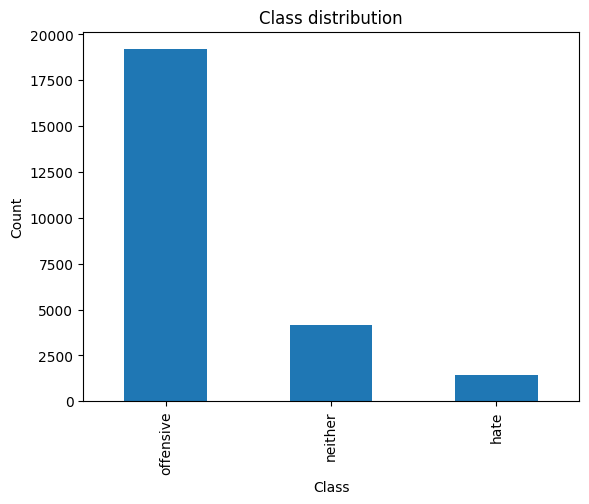


--- HATE ---


,label_name,tweet
2499,hate,@AustinG1135 I do not like talking to you fagg...
19697,hate,RT @mitchmancuso: @BrantPrintup:What straight ...



--- OFFENSIVE ---


,label_name,tweet
22889,offensive,Why is it everytime I go to cracker barrel the...
20565,offensive,"Run that nigga, you don't want that nigga, but..."



--- NEITHER ---


,label_name,tweet
18754,neither,RT @chicagotribune: Chicago will not refund $7...
21093,neither,"Sometimes, even I gotta tell these hoes to gro..."


In [5]:
#3 class classification: 0 is the label for hate, 1 for offensive and 2 for neither
label_map = {0: "hate", 1: "offensive", 2: "neither"}
df["label_name"] = df["label"].map(label_map)

#count each label
print("\nLabel counts:")
print(df["label_name"].value_counts())

# Plot distribution for labels
ax = df["label_name"].value_counts().plot(kind="bar")
ax.set_title("Class distribution")
ax.set_xlabel("Class")
ax.set_ylabel("Count")
plt.show()

# Show a few examples per class
for cls in ["hate", "offensive", "neither"]:
    print("\n---", cls.upper(), "---")
    display(df[df["label_name"] == cls][["label_name", "tweet"]].sample(2, random_state=SEED))

there is a class inbalance

Average number of chars: 85.43606504458701
Median chars: 81.0
95th percentile: 146.0


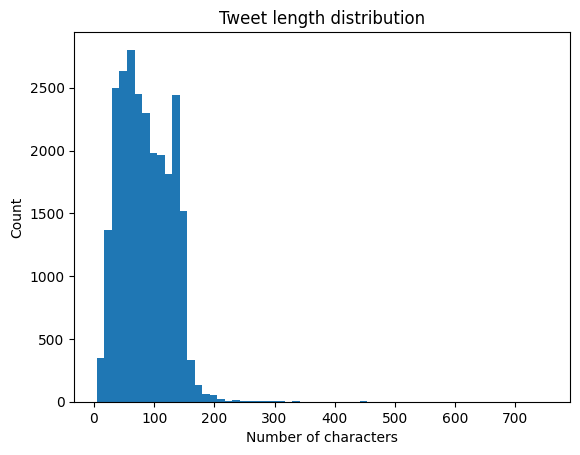

In [29]:
#exploratory analysis
char_orig = df["tweet"].astype(str).str.len()
print("Average number of chars:", char_orig.mean())
print("Median chars:", char_orig.median())
print("95th percentile:", np.percentile(char_orig, 95))

plt.hist(char_orig, bins=60)
plt.title("Tweet length distribution")
plt.xlabel("Number of characters")
plt.ylabel("Count")
plt.show()


In [7]:
#coping the data set to keep one version of the orginal
df_orig = df.copy(deep=True)

In [8]:
# The dataset includes counts of annotator votes I will use them to estimate an agreement.
#computing an "agreement" score (how strongly annotators agreed on the final label)

vote_cols = ["hate_speech", "offensive_language", "neither"]
df["max_votes"] = df[vote_cols].max(axis=1)

df["agreement"] = df["max_votes"] / df["count"].replace(0, np.nan)

print("Agreement summary:")
print(df["agreement"].describe())

print("\nLow-agreement examples (agreement <= 0.6):", (df["agreement"] <= 0.6).sum())
print("High-agreement examples (agreement >= 0.9):", (df["agreement"] >= 0.9).sum())


Agreement summary:
count    24783.000000
mean         0.904954
std          0.149232
min          0.444444
25%          0.666667
50%          1.000000
75%          1.000000
max          1.000000
Name: agreement, dtype: float64

Low-agreement examples (agreement <= 0.6): 71
High-agreement examples (agreement >= 0.9): 17482


Agreement mean is roughly 0.905, with most items at 1.0 → the dataset is mostly “easy” for annotators, but there is a small noisy slice (71 low-agreement).

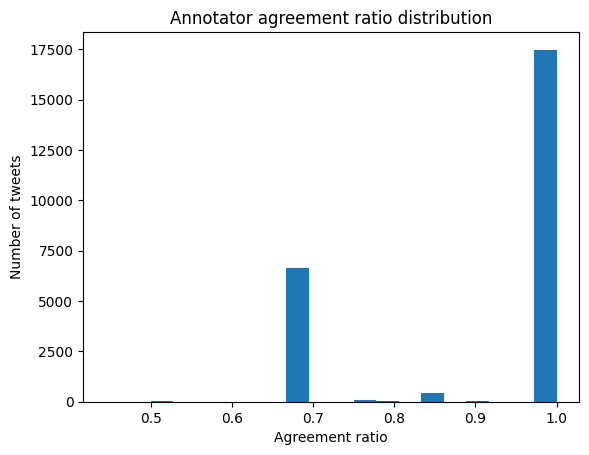

In [9]:
plt.hist(df["agreement"], bins=20)
plt.title("Annotator agreement ratio distribution")
plt.xlabel("Agreement ratio")
plt.ylabel("Number of tweets")
plt.show()



Hashtags present: {False: 17149, True: 7634}
URLs present    : {False: 21758, True: 3025}
Mentions present: {True: 14189, False: 10594}
Empty token lists: 0


,label,tweet,text_proc
2281,1,934 8616\ni got a missed call from yo bitch,nine hundr thirti four eight thousand six hund...
15914,1,RT @KINGTUNCHI_: Fucking with a bad bitch you ...,mentiontoken fuck bad bitch gone need money li...
18943,2,RT @eanahS__: @1inkkofrosess lol my credit ain...,mentiontoken mentiontoken lol credit near good...


Avg tokens per tweet: 8.074284791994513
Median tokens: 8.0
Most common token length: 5  (count: 2552 )


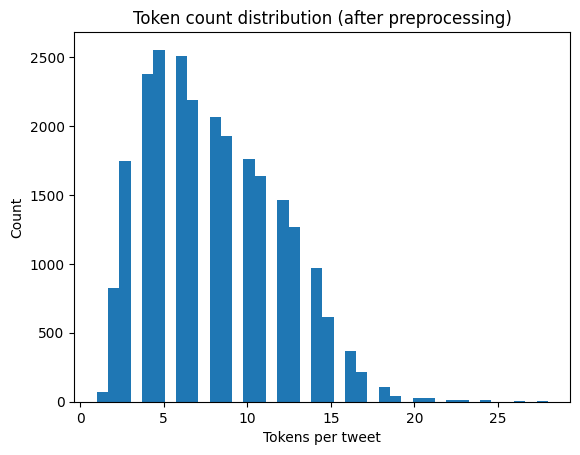

In [10]:
#Preprocessing
# lowercase -> normalize hashtags/urls/mentions/rt -> digits to words -> cleanup -> reduce char repeats
# -> expand contractions -> tokenize -> stopwords removal -> stemming

# checking to see if hashtags, URLs and mentions are present
print("Hashtags present:", df["tweet"].astype(str).str.contains(r"#\w+", regex=True).value_counts().to_dict())
print("URLs present    :", df["tweet"].astype(str).str.contains(r"http\S+|www\.\S+", regex=True).value_counts().to_dict())
print("Mentions present:", df["tweet"].astype(str).str.contains(r"@\w+", regex=True).value_counts().to_dict())

num_engine = inflect.engine()
stop_en = set(stopwords.words("english"))
stemmer = SnowballStemmer("english")

URL_RE = re.compile(r"http\S+|www\.\S+")
MENTION_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#(\w+)")
DIGIT_RE = re.compile(r"\d+")
REPEAT_RE = re.compile(r"(.)\1{2,}")  # 3+ repeats

def digits_to_words(s: str) -> str:
    return DIGIT_RE.sub(lambda m: num_engine.number_to_words(m.group()), s)

def preprocess_tweet(s: str) -> list:
    s = html.unescape(str(s))

    # 1) lowercase
    s = s.lower()

    # 2) handle hashtags (keep the word, drop '#')
    s = HASHTAG_RE.sub(r"\1", s)

    # 3) remove urls
    s = URL_RE.sub(" ", s)

    # 4) replace mentions with a token
    s = MENTION_RE.sub(" mentiontoken ", s)

    # remove standalone rt
    s = re.sub(r"\brt\b", " ", s)

    # 5) digits -> words
    s = digits_to_words(s)

    # 6) remove punctuation / non-letters + newlines
    s = re.sub(r"[^a-z\s]", " ", s).replace("\n", " ")

    # 7) reduce long character repetitions (keep 2 chars instead of 1)
    s = REPEAT_RE.sub(r"\1\1", s)

    # 8) expand contractions
    s = contractions.fix(s)

    # cleanup spaces
    s = re.sub(r"\s+", " ", s).strip()

    # 9) tokenize
    tokens = word_tokenize(s)

    # 10) remove stopwords + very short tokens
    tokens = [t for t in tokens if t not in stop_en and len(t) >= 2]

    # 11) stemming
    tokens = [stemmer.stem(t) for t in tokens]

    return tokens

# Apply to whole dataset
df["tokens_proc"] = df["tweet"].astype(str).apply(preprocess_tweet)

# Drop empties
empty_mask = df["tokens_proc"].apply(len) == 0
print("Empty token lists:", empty_mask.sum())
df = df.loc[~empty_mask].reset_index(drop=True)

# Making a string version for TF-IDF later
df["text_proc"] = df["tokens_proc"].apply(lambda toks: " ".join(toks))

# show raw -> processed
preview = df.sample(3, random_state=SEED)[["label", "tweet", "text_proc"]]
display(preview)

# Token length stats + distribution
tok_len = df["tokens_proc"].apply(len)
print("Avg tokens per tweet:", tok_len.mean())
print("Median tokens:", tok_len.median())
print("Most common token length:", tok_len.value_counts().idxmax(), " (count:", tok_len.value_counts().max(), ")")

plt.hist(tok_len, bins=40)
plt.title("Token count distribution (after preprocessing)")
plt.xlabel("Tokens per tweet")
plt.ylabel("Count")
plt.show()


In [11]:
#Train/test split
label_map = {0: "hate", 1: "offensive", 2: "neither"}

X = df["text_proc"].astype(str)     #processed text (stemmed tokens joined)
y = df["label"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

print("\nTrain label distribution:")
print(y_train.map(label_map).value_counts())

print("\nTest label distribution:")
print(y_test.map(label_map).value_counts())


Train size: 19826
Test size: 4957

Train label distribution:
label
offensive    15352
neither       3330
hate          1144
Name: count, dtype: int64

Test label distribution:
label
offensive    3838
neither       833
hate          286
Name: count, dtype: int64


In [31]:
#TF-IDF vectorization

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True
)

Xtr = tfidf.fit_transform(X_train)
Xte = tfidf.transform(X_test)

print("TF-IDF train shape:", Xtr.shape)
print("TF-IDF test shape :", Xte.shape)
print("Vocabulary size:", len(tfidf.get_feature_names_out()))
print("Train matrix density:", Xtr.nnz / (Xtr.shape[0] * Xtr.shape[1]))

#show a few feature names
print("\nSample features:", tfidf.get_feature_names_out()[:15])


TF-IDF train shape: (19826, 10813)
TF-IDF test shape : (4957, 10813)
Vocabulary size: 10813
Train matrix density: 0.0008786933699491878

Sample features: ['aa' 'aaron' 'ab' 'abil' 'abl' 'abo' 'abort' 'absolut' 'abu' 'abus' 'ac'
 'accent' 'accept' 'accept fact' 'accid']


In [13]:
#This baseline gives a reference point before XGBoost, is fast and usually strong with TF-IDF features
#Baseline model: Logistic Regression

label_order = [0, 1, 2]
label_names = ["hate", "offensive", "neither"]

lr = LogisticRegression(
    max_iter=3000,
    n_jobs=-1,
    class_weight="balanced",
    random_state=SEED
)

lr.fit(Xtr, y_train)
pred_lr = lr.predict(Xte)

print("Macro F1:", f1_score(y_test, pred_lr, average="macro"))
print("F1 (hate):", f1_score(y_test, pred_lr, labels=[0], average=None)[0])
print("\nClassification report:\n")
print(classification_report(y_test, pred_lr, labels=label_order, target_names=label_names))



Macro F1: 0.7428429975019885
F1 (hate): 0.4427672955974843

Classification report:

              precision    recall  f1-score   support

        hate       0.35      0.62      0.44       286
   offensive       0.97      0.87      0.92      3838
     neither       0.80      0.95      0.87       833

    accuracy                           0.87      4957
   macro avg       0.70      0.81      0.74      4957
weighted avg       0.90      0.87      0.88      4957



Macro F1: 0.7291113074703546
F1 (hate): 0.34782608695652173

Classification report:

              precision    recall  f1-score   support

        hate       0.56      0.25      0.35       286
   offensive       0.94      0.95      0.95      3838
     neither       0.84      0.95      0.89       833

    accuracy                           0.91      4957
   macro avg       0.78      0.72      0.73      4957
weighted avg       0.90      0.91      0.90      4957



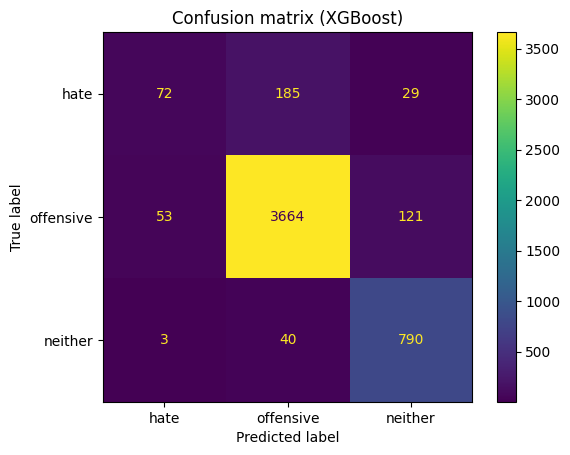

In [14]:
#XGBoost


label_order = [0, 1, 2]
label_names = ["hate", "offensive", "neither"]

xgb_model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    n_estimators=400,
    max_depth=6,
    learning_rate=0.08,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=SEED,
    n_jobs=-1
)

xgb_model.fit(Xtr, y_train)
pred_xgb = xgb_model.predict(Xte)

print("Macro F1:", f1_score(y_test, pred_xgb, average="macro"))
print("F1 (hate):", f1_score(y_test, pred_xgb, labels=[0], average=None)[0])
print("\nClassification report:\n")
print(classification_report(y_test, pred_xgb, labels=label_order, target_names=label_names))

cm = confusion_matrix(y_test, pred_xgb, labels=label_order)
ConfusionMatrixDisplay(cm, display_labels=label_names).plot(values_format="d")
plt.title("Confusion matrix (XGBoost)")
plt.show()


With TF-IDF features extracted from the preprocessed tweets, Logistic Regression achieves macro-F1 = 0.74 and detects the minority hate class relatively well (F1(hate) = 0.44, recall = 0.62). In contrast, the unweighted XGBoost model reaches a similar overall macro-F1 (0.72) and higher accuracy, but it is more conservative on the hate class (F1(hate) = 0.35, recall = 0.25). The confusion matrix confirms that a large fraction of true hate tweets are predicted as offensive (185/286), suggesting that the boundary between hate and offensive language is difficult to separate using lexical cues alone and that the two categories share overlapping vocabulary.
To mitigate the strong class imbalance and encourage the model to pay more attention to minority classes (especially hate), it's good to train XGBoost with class-balanced sample weights and re-evaluate macro-F1 and F1(hate).

Macro F1: 0.7415747733206893
F1 (hate): 0.424090338770389

Classification report:

              precision    recall  f1-score   support

        hate       0.33      0.59      0.42       286
   offensive       0.97      0.88      0.92      3838
     neither       0.82      0.95      0.88       833

    accuracy                           0.87      4957
   macro avg       0.71      0.81      0.74      4957
weighted avg       0.91      0.87      0.88      4957



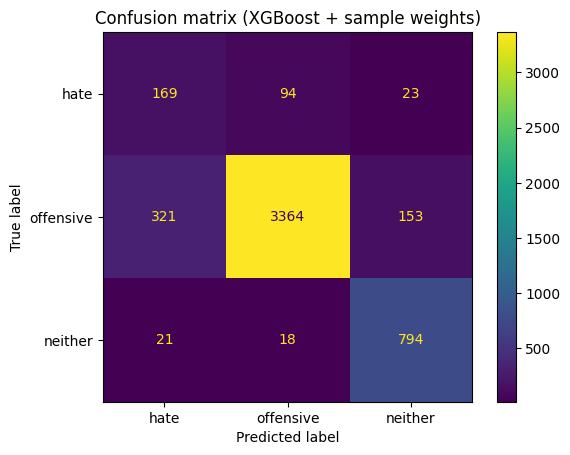

In [15]:
#XGBoost + sample weights

sample_w = compute_sample_weight(class_weight="balanced", y=y_train)

xgb_w = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    n_estimators=500,
    max_depth=6,
    learning_rate=0.06,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=SEED,
    n_jobs=-1
)

xgb_w.fit(Xtr, y_train, sample_weight=sample_w)
pred_xgb_w = xgb_w.predict(Xte)

label_order = [0, 1, 2]
label_names = ["hate", "offensive", "neither"]

print("Macro F1:", f1_score(y_test, pred_xgb_w, average="macro"))
print("F1 (hate):", f1_score(y_test, pred_xgb_w, labels=[0], average=None)[0])
print("\nClassification report:\n")
print(classification_report(y_test, pred_xgb_w, labels=label_order, target_names=label_names))

cm = confusion_matrix(y_test, pred_xgb_w, labels=label_order)
ConfusionMatrixDisplay(cm, display_labels=label_names).plot(values_format="d")
plt.title("Confusion matrix (XGBoost + sample weights)")
plt.show()



now the model is shifter toward the minority class: F1(hate) increases from 0.34 to 0.42 (hate recall from 0.25 to 0.59), and macro-F1 improves to 0.74, at the cost of a lower overall accuracy (0.87 vs 0.91). In the weighted confusion matrix, the number of correctly predicted hate tweets increases substantially (169 vs 72), while some offensive tweets are more often misclassified as hate, reflecting the trade-off introduced by imbalance handling.

# 9. Lexical explanation

In [16]:
#one way is to do the lexical explanation via Logistic Regression coefficients to extract the strongest words for each class.

feature_names = np.array(tfidf.get_feature_names_out())

# Align coefficient rows with class labels
# lr.classes_ should be [0,1,2]
class_to_row = {c:i for i,c in enumerate(lr.classes_)}

rows = []
TOPK = 25

for cls, cls_name in zip([0,1,2], ["hate","offensive","neither"]):
    row = class_to_row[cls]
    coef = lr.coef_[row]
    top_idx = np.argsort(coef)[-TOPK:][::-1]
    for rank, j in enumerate(top_idx, start=1):
        rows.append({"class": cls_name, "rank": rank, "token": feature_names[j], "weight": float(coef[j])})

coef_df = pd.DataFrame(rows)
display(coef_df.head(10))


coef_df.to_csv("lr_top_tokens.csv", index=False)
print("Saved: lr_top_tokens.csv")


,class,rank,token,weight
0,hate,1,faggot,7.710553
1,hate,2,nigger,6.744772
2,hate,3,nigga,6.119830
3,hate,4,fag,5.604981
4,hate,5,fuck,4.404329
5,hate,6,queer,4.155953
6,hate,7,white,4.110092
7,hate,8,dyke,3.984908
8,hate,9,coon,3.464775
9,hate,10,wetback,3.450503


Saved: lr_top_tokens.csv


In [17]:
#second way SHAP explanation for XGBoost to find top tokens per class

model_for_shap = xgb_w   #weighted XGBoost

np.random.seed(SEED)
idx = np.random.choice(Xte.shape[0], size=500, replace=False)
X_sample = Xte[idx]

explainer = shap.TreeExplainer(model_for_shap)
shap_vals = explainer.shap_values(X_sample)

feature_names = np.array(tfidf.get_feature_names_out())

# Handling both list-of-arrays OR 3D array
if isinstance(shap_vals, list):
    sv_list = shap_vals  # [class0, class1, class2], each (n_samples, n_features)
else:
    # shape (n_samples, n_features, n_classes)
    sv_list = [shap_vals[:, :, i] for i in range(shap_vals.shape[2])]

# Filter out very short tokens that often look meaningless in TF-IDF
valid = np.array([len(t) >= 3 for t in feature_names])

TOPK = 25
rows = []
for cls, cls_name in zip([0,1,2], ["hate","offensive","neither"]):
    mean_abs = np.abs(sv_list[cls]).mean(axis=0)
    mean_abs = mean_abs * valid  # zero-out invalid short tokens

    top_idx = np.argsort(mean_abs)[-TOPK:][::-1]
    for rank, j in enumerate(top_idx, start=1):
        rows.append({
            "class": cls_name,
            "rank": rank,
            "token": feature_names[j],
            "mean_abs_shap": float(mean_abs[j])
        })

shap_df = pd.DataFrame(rows)
shap_df.to_csv("xgb_shap_top_tokens.csv", index=False)
print("Saved: xgb_shap_top_tokens.csv")

#show only NEITHER class
display(shap_df[shap_df["class"]=="neither"].head(15))



Saved: xgb_shap_top_tokens.csv


,class,rank,token,mean_abs_shap
50,neither,1,bitch,1.736279
51,neither,2,hoe,0.388248
52,neither,3,fuck,0.316200
53,neither,4,pussi,0.260780
54,neither,5,nigga,0.253182
55,neither,6,ass,0.212188
56,neither,7,faggot,0.144237
57,neither,8,shit,0.130680
58,neither,9,nigger,0.118686
59,neither,10,retard,0.101271


Right now the “neither” SHAP list still contains a lot of profanity terms. That can happen because:

In this dataset, “neither” can still include insults that annotators didn’t mark as hate/offensive (label policy issue / noise), and

SHAP aggregation is “global” over the whole sample; it’s more meaningful to compute SHAP only on examples predicted as that class (or only true class examples).

I add a SHAP class-conditional (more interpretable)

In [18]:
#Class-conditional SHAP (predicted class)

model_for_shap = xgb_w

# Using the same X_sample already created in SHAP section
pred_sample = model_for_shap.predict(X_sample)  # predicted labels for the SHAP sample

feature_names = np.array(tfidf.get_feature_names_out())
valid = np.array([len(t) >= 3 for t in feature_names])

def top_tokens_for_class(cls, cls_name, mask, TOPK=25):
    # sv_list[cls] has shape (n_samples, n_features)
    mean_abs = np.abs(sv_list[cls][mask]).mean(axis=0)
    mean_abs = mean_abs * valid
    top_idx = np.argsort(mean_abs)[-TOPK:][::-1]
    rows = []
    for rank, j in enumerate(top_idx, start=1):
        rows.append({"class": cls_name, "rank": rank, "token": feature_names[j], "mean_abs_shap": float(mean_abs[j])})
    return rows

rows = []
for cls, cls_name in zip([0,1,2], ["hate","offensive","neither"]):
    mask = (pred_sample == cls)
    print(cls_name, "samples in SHAP subset:", mask.sum())
    rows.extend(top_tokens_for_class(cls, cls_name, mask, TOPK=25))

shap_pred_df = pd.DataFrame(rows)
shap_pred_df.to_csv("xgb_shap_top_tokens_predclass.csv", index=False)
print("Saved: xgb_shap_top_tokens_predclass.csv")


display(shap_pred_df[shap_pred_df["class"]=="neither"].head(15))
display(shap_pred_df[shap_pred_df["class"]=="hate"].head(15))


hate samples in SHAP subset: 44
offensive samples in SHAP subset: 352
neither samples in SHAP subset: 104
Saved: xgb_shap_top_tokens_predclass.csv


,class,rank,token,mean_abs_shap
50,neither,1,bitch,0.414108
51,neither,2,hoe,0.139863
52,neither,3,faggot,0.126934
53,neither,4,bird,0.108356
54,neither,5,yellow,0.108044
55,neither,6,yanke,0.106138
56,neither,7,fuck,0.100621
57,neither,8,ass,0.089668
58,neither,9,retard,0.086936
59,neither,10,nigger,0.085816


,class,rank,token,mean_abs_shap
0,hate,1,nigger,0.326425
1,hate,2,faggot,0.264741
2,hate,3,nigga,0.182665
3,hate,4,fag,0.149508
4,hate,5,white,0.138326
5,hate,6,coon,0.136190
6,hate,7,queer,0.130031
7,hate,8,kill,0.101372
8,hate,9,retard,0.061952
9,hate,10,mentiontoken,0.058933


In [19]:
# Lexical explanation via Logistic Regression coefficients


feat = np.array(tfidf.get_feature_names_out())

# map class label -> row in lr.coef_
row_for_class = {c: i for i, c in enumerate(lr.classes_)}

TOPK = 25
rows = []

for cls, cls_name in zip([0, 1, 2], ["hate", "offensive", "neither"]):
    coef = lr.coef_[row_for_class[cls]]
    top_idx = np.argsort(coef)[-TOPK:][::-1]
    for rank, j in enumerate(top_idx, start=1):
        rows.append({"class": cls_name, "rank": rank, "token": feat[j], "weight": float(coef[j])})

lr_terms = pd.DataFrame(rows)
lr_terms.to_csv("lr_top_tokens.csv", index=False)
print("Saved: lr_top_tokens.csv")

display(lr_terms.head(10))


Saved: lr_top_tokens.csv


,class,rank,token,weight
0,hate,1,faggot,7.710553
1,hate,2,nigger,6.744772
2,hate,3,nigga,6.119830
3,hate,4,fag,5.604981
4,hate,5,fuck,4.404329
5,hate,6,queer,4.155953
6,hate,7,white,4.110092
7,hate,8,dyke,3.984908
8,hate,9,coon,3.464775
9,hate,10,wetback,3.450503


In [20]:
#SHAP top tokens (global) for weighted XGBoost


model_for_shap = xgb_w
feat = np.array(tfidf.get_feature_names_out())

np.random.seed(SEED)
idx = np.random.choice(Xte.shape[0], size=400, replace=False)
X_sample = Xte[idx]

explainer = shap.TreeExplainer(model_for_shap)
shap_vals = explainer.shap_values(X_sample)

# handle shap output formats
if isinstance(shap_vals, list):
    sv_list = shap_vals
else:
    sv_list = [shap_vals[:, :, i] for i in range(shap_vals.shape[2])]

valid = np.array([len(t) >= 3 for t in feat])

TOPK = 25
rows = []
for cls, cls_name in zip([0, 1, 2], ["hate", "offensive", "neither"]):
    mean_abs = np.abs(sv_list[cls]).mean(axis=0) * valid
    top_idx = np.argsort(mean_abs)[-TOPK:][::-1]
    for rank, j in enumerate(top_idx, start=1):
        rows.append({"class": cls_name, "rank": rank, "token": feat[j], "mean_abs_shap": float(mean_abs[j])})

shap_global = pd.DataFrame(rows)
shap_global.to_csv("xgb_shap_top_tokens.csv", index=False)
print("Saved: xgb_shap_top_tokens.csv")

display(shap_global[shap_global["class"]=="hate"].head(10))


Saved: xgb_shap_top_tokens.csv


,class,rank,token,mean_abs_shap
0,hate,1,nigga,0.138232
1,hate,2,faggot,0.120196
2,hate,3,nigger,0.101501
3,hate,4,white,0.089358
4,hate,5,bird,0.072178
5,hate,6,fag,0.055192
6,hate,7,bitch,0.045824
7,hate,8,mentiontoken,0.043073
8,hate,9,kill,0.038178
9,hate,10,coon,0.035573


In [21]:
#SHAP top tokens conditioned on predicted class
pred_sample = model_for_shap.predict(X_sample)

def top_for_class(cls, cls_name):
    mask = (pred_sample == cls)
    print(cls_name, "samples in SHAP subset:", int(mask.sum()))
    mean_abs = np.abs(sv_list[cls][mask]).mean(axis=0) * valid
    top_idx = np.argsort(mean_abs)[-TOPK:][::-1]
    return [{"class": cls_name, "rank": r, "token": feat[j], "mean_abs_shap": float(mean_abs[j])}
            for r, j in enumerate(top_idx, start=1)]

rows = []
rows += top_for_class(0, "hate")
rows += top_for_class(1, "offensive")
rows += top_for_class(2, "neither")

shap_pred = pd.DataFrame(rows)
shap_pred.to_csv("xgb_shap_top_tokens_predclass.csv", index=False)
print("Saved: xgb_shap_top_tokens_predclass.csv")

display(shap_pred[shap_pred["class"]=="hate"].head(10))


hate samples in SHAP subset: 34
offensive samples in SHAP subset: 298
neither samples in SHAP subset: 68
Saved: xgb_shap_top_tokens_predclass.csv


,class,rank,token,mean_abs_shap
0,hate,1,nigger,0.359013
1,hate,2,faggot,0.259351
2,hate,3,nigga,0.182868
3,hate,4,white,0.163890
4,hate,5,queer,0.162428
5,hate,6,coon,0.132938
6,hate,7,kill,0.124840
7,hate,8,fag,0.115197
8,hate,9,whitey,0.060432
9,hate,10,beaner,0.059505


 98%|===================| 886/900 [01:19<00:01]       

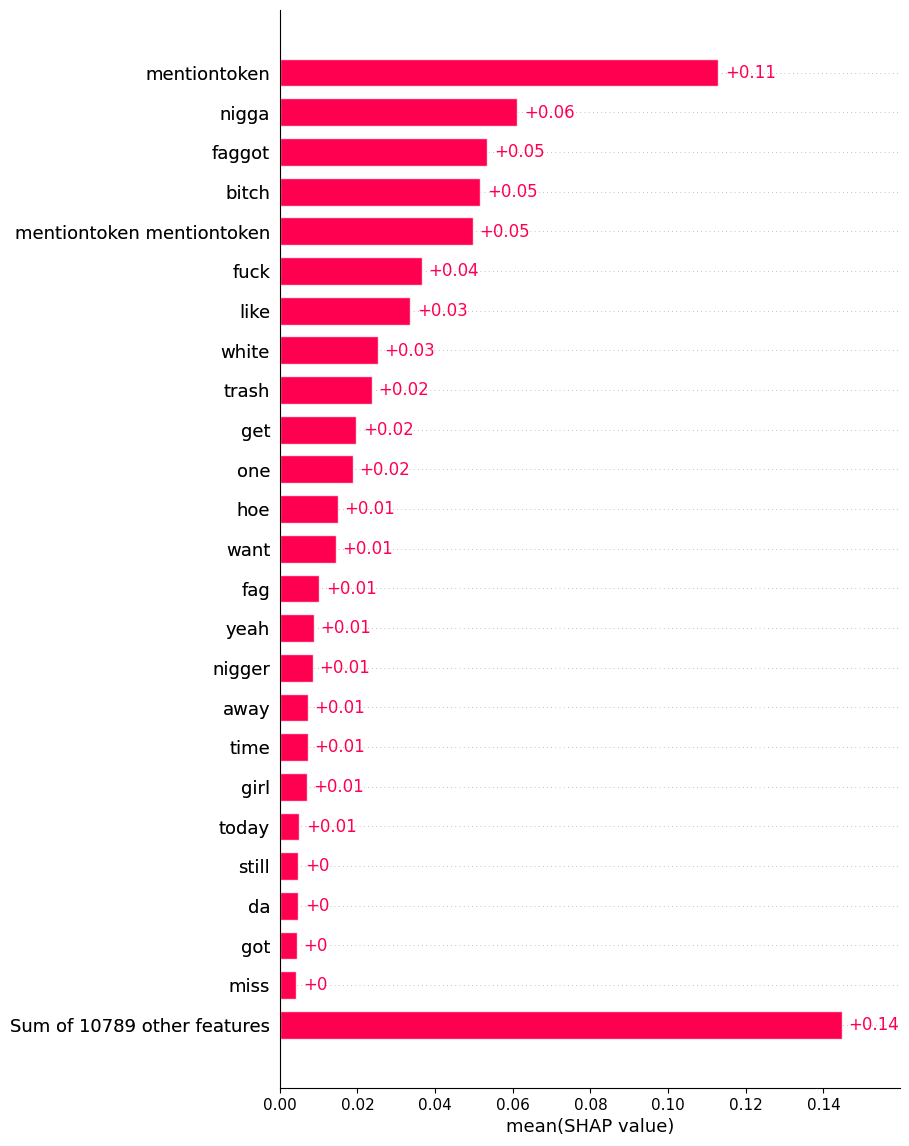

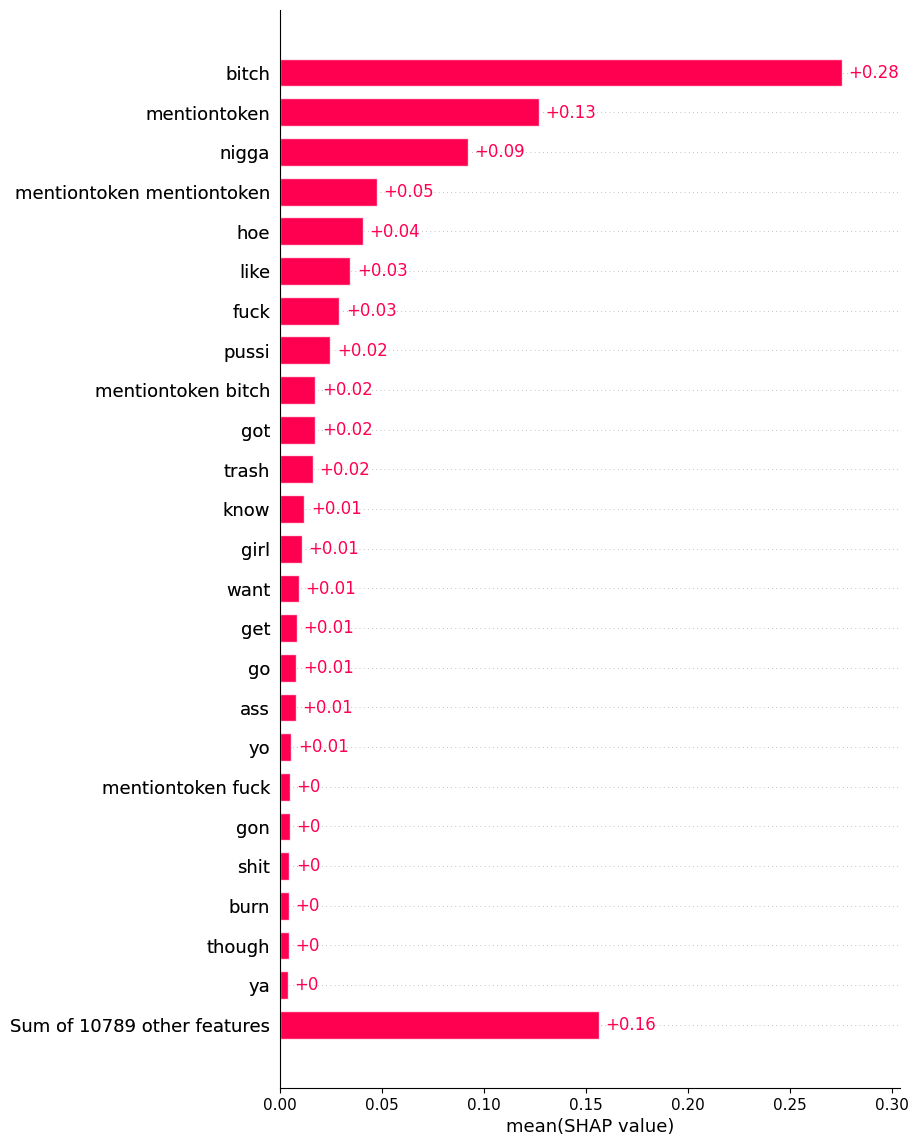

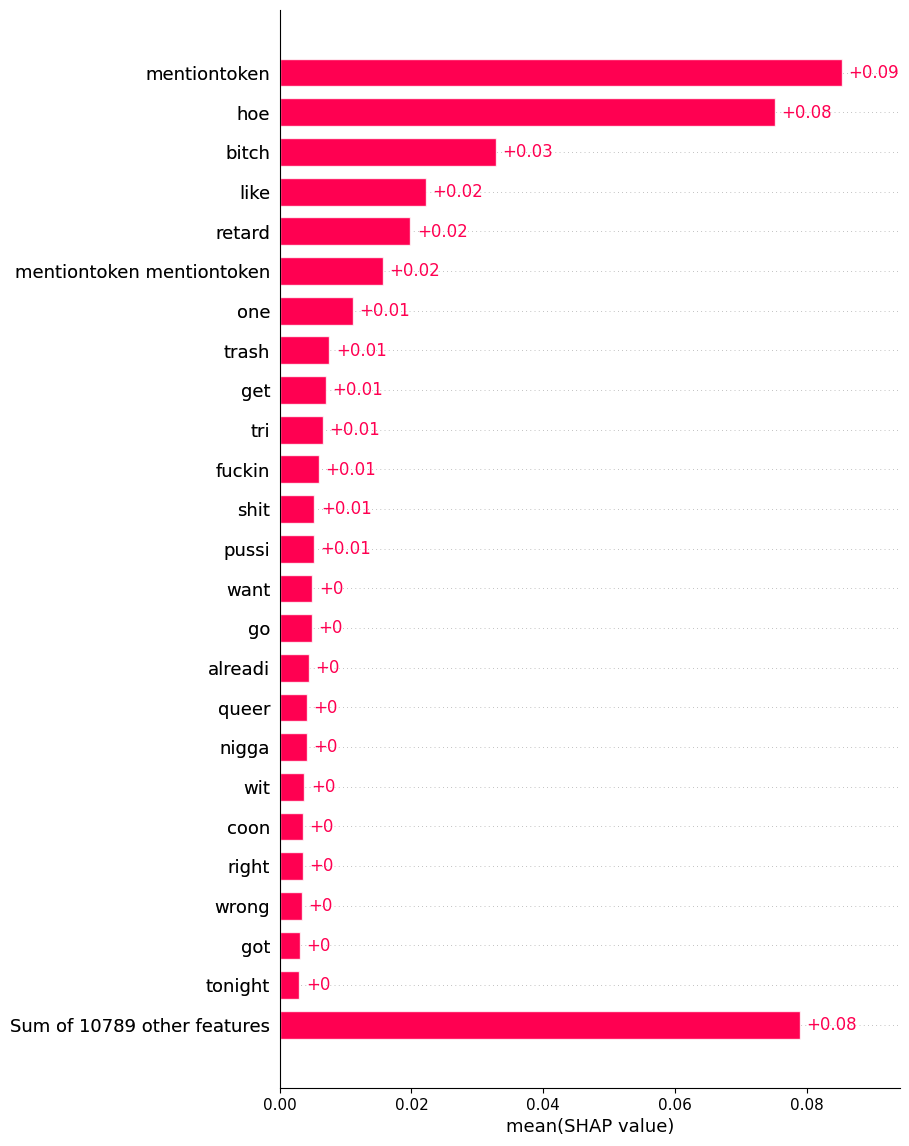

In [32]:
#SHAP bar plots (mean absolute SHAP)
import shap
import numpy as np

np.random.seed(SEED)
bg_idx = np.random.choice(Xtr.shape[0], size=150, replace=False)
test_idx = np.random.choice(Xte.shape[0], size=300, replace=False)

background = Xtr[bg_idx].toarray()
labels_mat = Xte[test_idx].toarray()

expl = shap.Explainer(xgb_w, background)
shap_exp = expl(labels_mat)
shap_exp.feature_names = tfidf.get_feature_names_out()

def mean_abs_expl(exp_slice):
    out = exp_slice.mean(0)  # Explanation object, shape (n_features,)
    out.values = np.abs(exp_slice.values).mean(0)
    return out

shap.plots.bar(mean_abs_expl(shap_exp[:, :, 0]), max_display=25)  # hate
shap.plots.bar(mean_abs_expl(shap_exp[:, :, 1]), max_display=25)  # offensive
shap.plots.bar(mean_abs_expl(shap_exp[:, :, 2]), max_display=25)  # neither


In [23]:
#Error analysis + agreement
import pandas as pd
import numpy as np

pred = pred_xgb_w  # weighted XGB predictions

analysis_df = pd.DataFrame({
    "tweet_raw": df.loc[X_test.index, "tweet"].values,
    "tweet_proc": X_test.values,
    "true": y_test.values,
    "pred": pred
}, index=X_test.index)

name_map = {0:"hate", 1:"offensive", 2:"neither"}
analysis_df["true_name"] = analysis_df["true"].map(name_map)
analysis_df["pred_name"] = analysis_df["pred"].map(name_map)
analysis_df["correct"] = analysis_df["true"] == analysis_df["pred"]


if "agreement" in df.columns:
    analysis_df = analysis_df.join(df[["agreement"]], how="left")

print("Accuracy:", analysis_df["correct"].mean())

if "agreement" in analysis_df.columns:
    print("\nAgreement (mean) for correct vs incorrect:")
    print(analysis_df.groupby("correct")["agreement"].mean())

print("\nConfusion (row-normalized):")
print(pd.crosstab(analysis_df["true_name"], analysis_df["pred_name"], normalize="index"))

# common failure mode count
print("\nCount (hate -> offensive):", ((analysis_df["true_name"]=="hate") & (analysis_df["pred_name"]=="offensive")).sum())


Accuracy: 0.872907000201735

Agreement (mean) for correct vs incorrect:
correct
False    0.776455
True     0.925440
Name: agreement, dtype: float64

Confusion (row-normalized):
pred_name      hate   neither  offensive
true_name                               
hate       0.590909  0.080420   0.328671
neither    0.025210  0.953181   0.021609
offensive  0.083637  0.039865   0.876498

Count (hate -> offensive): 94


In [24]:
#Results summary table
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score

def summarize(name, y_true, y_pred):
    return {
        "model": name,
        "accuracy": accuracy_score(y_true, y_pred),
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
        "f1_hate": f1_score(y_true, y_pred, labels=[0], average=None)[0],
        "f1_offensive": f1_score(y_true, y_pred, labels=[1], average=None)[0],
        "f1_neither": f1_score(y_true, y_pred, labels=[2], average=None)[0],
    }

results_df = pd.DataFrame([
    summarize("LogReg (balanced)", y_test, pred_lr),
    summarize("XGBoost", y_test, pred_xgb),
    summarize("XGBoost + sample weights", y_test, pred_xgb_w),
])

display(results_df)
results_df.to_csv("results_summary.csv", index=False)
print("Saved: results_summary.csv")


,model,accuracy,macro_f1,f1_hate,f1_offensive,f1_neither
0,LogReg (balanced),0.870284,0.742843,0.442767,0.917341,0.868421
1,XGBoost,0.913052,0.729111,0.347826,0.948363,0.891145
2,XGBoost + sample weights,0.872907,0.741575,0.424090,0.919880,0.880754


Saved: results_summary.csv


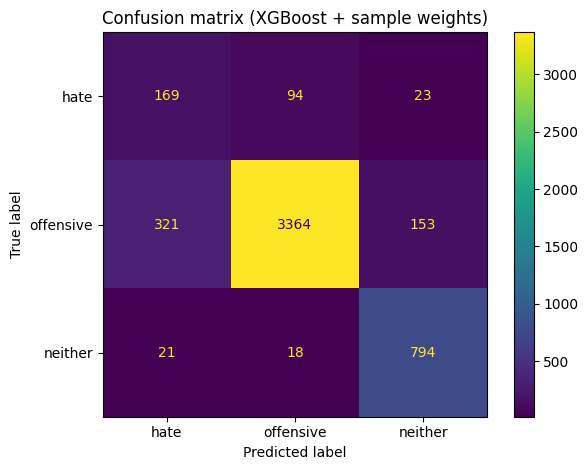

Saved: cm_xgb_weighted.png


In [25]:
#Save confusion matrix figure (weighted XGBoost)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

label_order = [0, 1, 2]
label_names = ["hate", "offensive", "neither"]

cm = confusion_matrix(y_test, pred_xgb_w, labels=label_order)
ConfusionMatrixDisplay(cm, display_labels=label_names).plot(values_format="d")
plt.title("Confusion matrix (XGBoost + sample weights)")
plt.tight_layout()
plt.savefig("cm_xgb_weighted.png", dpi=200)
plt.show()

print("Saved: cm_xgb_weighted.png")


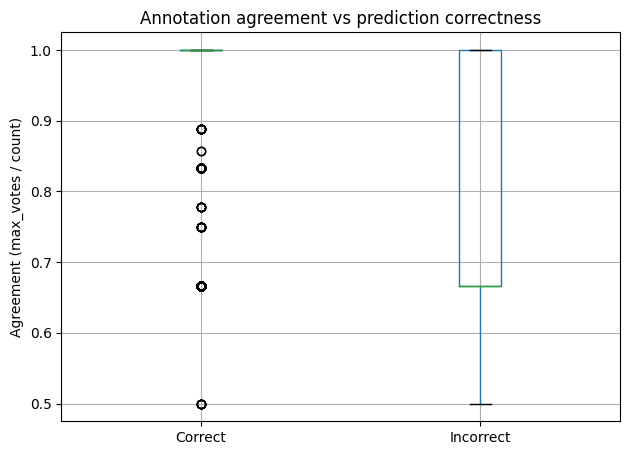

Saved: agreement_vs_correctness.png


In [26]:
# Agreement vs correctness plot
import matplotlib.pyplot as plt

if "agreement" in analysis_df.columns:
    tmp = analysis_df.copy()
    tmp["correct_str"] = tmp["correct"].map({True: "Correct", False: "Incorrect"})

    tmp.boxplot(column="agreement", by="correct_str")
    plt.suptitle("")
    plt.title("Annotation agreement vs prediction correctness")
    plt.xlabel("")
    plt.ylabel("Agreement (max_votes / count)")
    plt.tight_layout()
    plt.savefig("agreement_vs_correctness.png", dpi=200)
    plt.show()

    print("Saved: agreement_vs_correctness.png")
else:
    print("No 'agreement' column found — skip plot.")
